In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import time
from utils import *
import copy
from hcipy import *
import os
%load_ext autoreload
%autoreload 2

## Telescope Setup
Starting with the Magellan pupil (scaled to 3.048 m) till we get a description of the Shane pupil 

In [2]:
pupil_diameter = 3.048 # (meter)
collecting_area = np.pi * (3.048**2 - 0.9779**2)

f_number = 13 # effective focal ratio
effective_focal_length = pupil_diameter * f_number # (meter)

filter_name = 'V'
wavelength = filters[filter_name]['lambda_eff'] * 1e-6 # (meter)


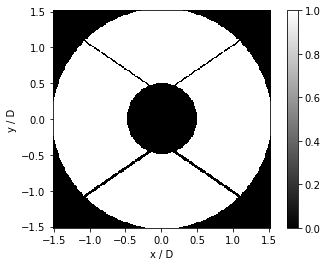

In [3]:
# Generating the pupil grid
grid_size = 256

pupil_grid = make_pupil_grid(grid_size, diameter=pupil_diameter)

# Adjust spiders to represent Shane pupil
telescope_pupil_generator = make_lick_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)

im = imshow_field(telescope_pupil, cmap='gray', )
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()

## Setting Up the Atmosphere
seeing estimated from the following source: 
https://mthamilton.ucolick.org/techdocs/MH_weather/obstats/avg_seeing.html

In [4]:
seeing = 1.75
outer_scale = 40. # (meter) --> GUESS, NEEDS REFINING
velocity = 20. # (m/s) --> GUESS, NEEDS REFINING
                                    
fried_parameter = seeing_to_fried_parameter(seeing, wavelength)
                             
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)

tau0 = 0.314 * fried_parameter/velocity

print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 6.3cm
L0   = 40.0m
tau0 = 1.0ms
v    = 20.0m/s


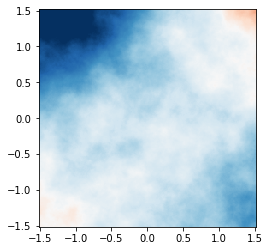

In [5]:
# Generating phase screens
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength) # (radian)
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, vmin=-2*np.pi, vmax=2*np.pi, cmap='RdBu')

In [6]:
# Propagating to focal plane

nairy = 20

focal_grid = make_focal_grid(q=4, 
                             num_airy=nairy,
                             pupil_diameter=pupil_diameter,
                             focal_length = effective_focal_length,
                             reference_wavelength=wavelength)

prop = FraunhoferPropagator(pupil_grid, focal_grid, 
                            focal_length=effective_focal_length)

## Add a Primary and Companion

In [7]:
# Primary parameters
mag = 17 #Vega magnitude in the band of interest
stokes_vector= [1.,0.,0.,0.] #I, Q, U, V

# Companion parameters
contrast = 0.
stokes_ps = [1.,0.,0.,0.] #I, Q, U, V
angular_separation= 2 #Lambda/D

# Exposure time and total number of exposures
exposure_time = 0.01 # (seconds)
exposure_total = 2

### Simulating Image Data

In [8]:
from scipy.ndimage import gaussian_filter

def center_image(img, gsigma, cpix):
#   [img] - image array
#   [gsigma] - standard deviation for Gaussian kernel
#   [cpix] - number of pixels in output image 
    im_o_g = gaussian_filter(img, sigma=gsigma)
    maximum = np.where(im_o_g == np.max(im_o_g))
    #print(maximum)
    #print(type(img))
    #print(type(im_o_g))
    #imshow_field(img)
    #plt.imshow(im_o_g)
    x1 = int(maximum[0] - (cpix/2))
    x2 = int(maximum[0] + (cpix/2))
    
    y1 = int(maximum[1] - (cpix/2))
    y2 = int(maximum[1] + (cpix/2))
    
    center_image = img[x1:x2, y1:y2]
    return(center_image)


In [9]:
pupil_wavefront = Wavefront(telescope_pupil, wavelength,
                            input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In photons/s


wf_planet = Wavefront(telescope_pupil*np.exp(4j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),
                      wavelength,
                      input_stokes_vector=stokes_ps)
wf_planet.total_power = contrast * number_of_photons(mag,filter_name,collecting_area,) # (photons/s)

In [10]:
focal_grid.size

25600

In [11]:
detector = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True)
#detector = NoiselessDetector(focal_grid)
fps = 532
detector_size = 512 # width of shortest side of detector. Number of rows in the DETECTOR
number_of_rows = int(np.sqrt(focal_grid.size))# Width of the focal plane. Number of in rows the FOCAL PLANE.
row_readout_rate = 1/fps/detector_size
row_exposure_time = row_readout_rate

layer.t = exposure_time
for i in range(exposure_total):
    layer.t+=exposure_time
    image_comb = focal_grid.zeros()
    for j in range(int(number_of_rows)):
        layer_copy = copy.deepcopy(layer)
        layer_copy.t = row_readout_rate*j
        detector.integrate(prop((layer_copy(pupil_wavefront))),exposure_time)
        detector.integrate(prop((layer_copy(wf_planet))),exposure_time)   
        image_row = detector.read_out()
        #imshow_field(image_row)
        start = int(focal_grid.size*(j/number_of_rows))
        end = int(focal_grid.size*((j+1)/number_of_rows))
        image_comb[start:end]=image_row[start:end]        
        print("Percent complete = ", round((j+i*int(number_of_rows))/(number_of_rows*exposure_total) * 100, 3), end = '\r')
    npix = int(np.sqrt(len(image_comb)))    
    #print(type(image_comb))
    #imshow_field(image_comb)
    im_ft = image_comb.reshape([npix,npix])
    #print(type(im_ft))
    #imshow_field(im_ft)
#   image centering
    center_image(im_ft, 10, npix)
    
#   supergaussian window    
    if i == 0: sg = supergauss_hw(100,4, npix)
        
#   fourier transform
    FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_ft*sg)))
    
#   power spectrum
    PS = np.abs(FT/FT[int(npix/2),int(npix/2)])**2
    if i==0:
        PS_all = np.array(PS)
    else:
        PS_all+=PS


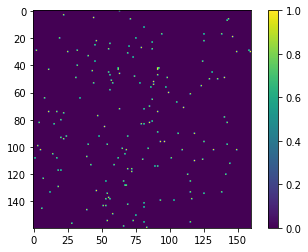

In [23]:
plt.imshow(image_comb.shaped)
plt.colorbar()

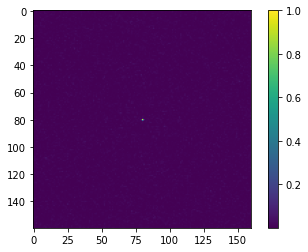

In [25]:
plt.imshow(PS)
plt.colorbar()

Text(0, 0.5, 'Mean')

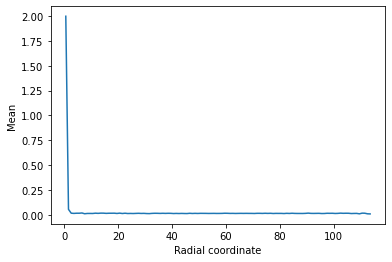

In [12]:
from radial_profile import radial_data

rad_stats = radial_data(PS_all)
plt.figure()
plt.plot(rad_stats.r, rad_stats.mean)
plt.xlabel('Radial coordinate')
plt.ylabel('Mean')

In [13]:
# Bias sub
PS_all_bsub = PS_all.copy()
PS_all_bsub -= np.mean(PS_all[700:,700:])

# Divide PS by azimuthal average at low frequencies (f < 0.2 fc = 0.2 D / lambda)

# Grid: 800 pixels across, equalling 200 lambda / D, plate scale is then 0.25*lambda / D per pixel
plate_scale = 0.25 * wavelength / pupil_diameter * 206265.   #of image in (arcsec / pixel)

# Plate scale in meters per pixel
ps_mpp = 1. / (npix * plate_scale) * 206265. * wavelength 
scaling = 0.5
fcut = pupil_diameter / ps_mpp * scaling

PS_all_filt = PS_all_bsub.copy()

for xx in range(len(PS_all_filt)):
    for yy in range(len(PS_all_filt)):
        rad = np.sqrt((xx-npix/2)**2+(yy-npix/2)**2)
        if rad < fcut:
            drad = rad_stats.r-rad
            val = rad_stats.mean[np.where(np.abs(drad)==np.min(np.abs(drad)))][0]
            PS_all_filt[yy,xx]/=val

/Users/maxwellmb/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/maxwellmb/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/maxwellmb/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/maxwellmb/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/maxwellmb/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


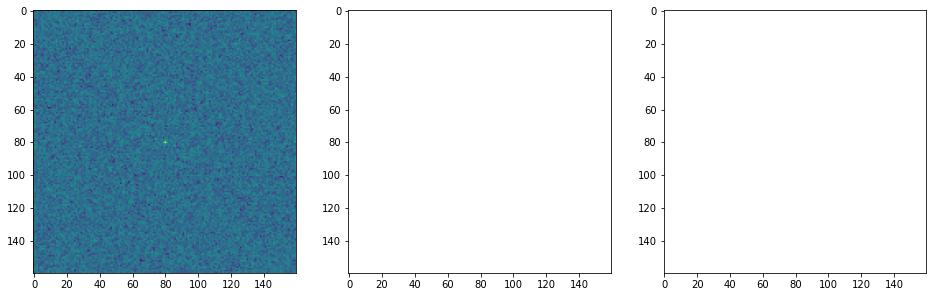

In [14]:
# Power spectrum plots

f = plt.figure(figsize=(16,10))
f.add_subplot(131)
plt.imshow(np.abs(PS_all)**0.1) # initial PS
f.add_subplot(132)
plt.imshow(np.abs(PS_all_bsub)**0.1) # PS w/ bias subtraction
f.add_subplot(133)
plt.imshow(np.abs(PS_all_filt)) # final filtered PS
plt.show()

### Autocorrelation Function 

In [15]:
# Generating the ACF 
ACF = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(PS_all)))

ACF_filt = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(PS_all_filt)))

ACF_filt_norm = ACF_filt / ACF_filt[int(npix/2),int(npix/2)]


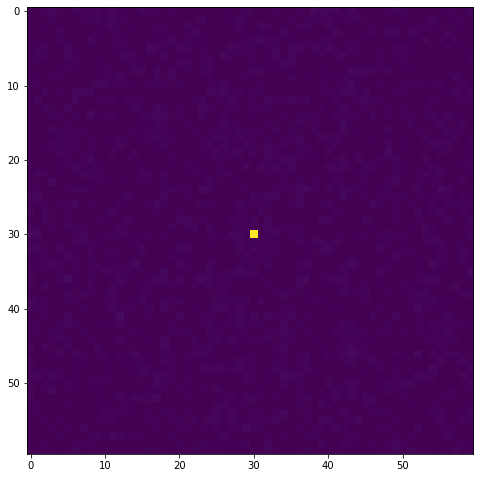

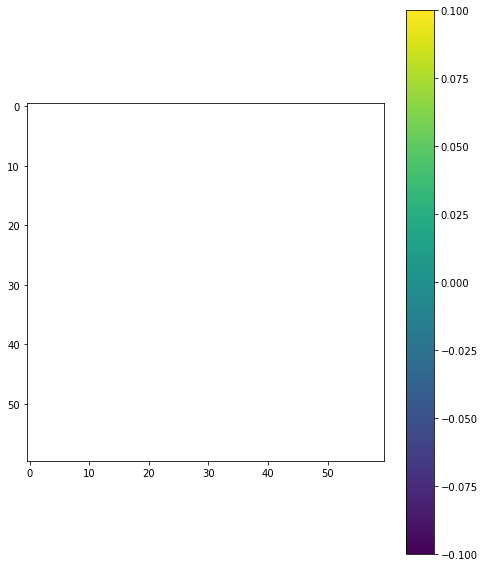

In [16]:
# Plotting ACF
fsub = 30

f = plt.figure(figsize=(8,10))
plt.imshow(np.abs(ACF)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
plt.show()

# Filtered & normalized ACF
f = plt.figure(figsize=(8,10))
plt.imshow(np.abs(ACF_filt_norm)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
plt.colorbar()
plt.show()

### Final Image, PS, and ACF

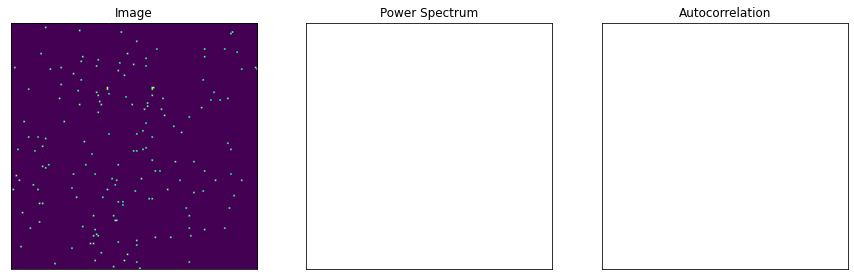

In [17]:
# Image, PS, and ACF plots
f = plt.figure(figsize=(15,5))
ax=f.add_subplot(131)
plt.imshow(im_ft**0.5)
ax.set_yticks([])
ax.set_xticks([])
plt.title('Image')
ax = f.add_subplot(132)
plt.title('Power Spectrum')
plt.imshow(np.abs(PS_all_filt))
ax.set_yticks([])
ax.set_xticks([])
ax=f.add_subplot(133)
plt.imshow(np.abs(ACF_filt_norm)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
ax.set_yticks([])
ax.set_xticks([])
plt.title('Autocorrelation')
plt.show()

# To save image:
#plt.savefig('speckle_imaging.png')

## Speckle Contrast Curve

In [18]:
def ACF_cc(ACF):
    return -2.5*np.log10((1.-np.sqrt(1.-(2*ACF)**2))/(2*ACF))

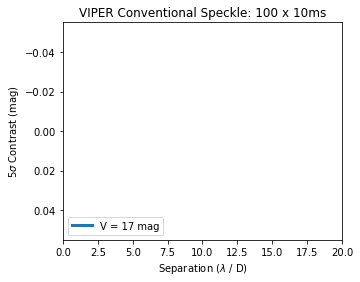

In [19]:
#Generating contrast curves

ACF_m = ACF_cc(ACF_filt_norm)
rad_ACF = radial_data(np.abs(ACF_filt_norm), annulus_width=2)
cc = ACF_cc(5*rad_ACF.std)


xax = np.array(range(len(rad_ACF.mean))) * plate_scale / ((wavelength) / pupil_diameter * 206265) #in lambda/D units

f = plt.figure(figsize=(5,4))
plt.plot(xax,cc,label='V = '+str(mag)+' mag',lw=3)
plt.xlim(0.0,20.0)
plt.gca().invert_yaxis()
plt.legend(loc='lower left')
plt.ylabel(r'5$\sigma$ Contrast (mag)')
plt.xlabel(r'Separation ($\lambda$ / D)')
plt.title('VIPER Conventional Speckle: 100 x 10ms')
plt.savefig('speckle_cont_conv_2.png',dpi=300)
plt.show()